In [130]:
import pandas as pd
import numpy as np

In [131]:
df = pd.read_csv('ECA_data.csv')
df.head()

,ID,LIMIT,BALANCE,INCOME,RATING,GENDER,EDUCATION,MARITAL,AGE,S1,...,B1,B2,B3,B4,B5,R1,R2,R3,R4,R5
0,1,210000,0.00,235822,1,1,1.0,2.0,30,0,...,0,0,0,0,0,0,0,0,0,0
1,2,260000,10928.05,278481,0,0,2.0,2.0,31,0,...,54074,46407,38874,31324,24031,2000,2000,2000,2000,72000
2,3,400000,65397.85,431993,0,0,3.0,1.0,51,0,...,343591,352484,338823,283288,185288,15000,14000,11500,8000,7000
3,4,20000,3695.30,22368,0,0,2.0,1.0,58,-1,...,21470,200,0,28740,1295,0,0,28740,1565,0
4,5,180000,68.25,166900,0,1,2.0,1.0,42,0,...,1260,598,2056,4300,1802,598,2056,4300,1802,3691


# Preprocessing

In [132]:
# Convert all the R3 values to integers and remove unnecessary characters.
not_numeric = []
for val in df['R3']:
    if not val.isnumeric():
        not_numeric.append(val)

def fix(df):
    new_df = []
    for val in df:
        if val.isnumeric():
            new_df.append(int(val))
        else:
            new_df.append(int(val[1:].replace(',', '')))
            
    return pd.Series(new_df)

df_fix = fix(list(df['R3']))       
df['R3'] = df_fix

In [133]:
# Remove values not within range provided (if any).
df.drop(df[df['EDUCATION'] > 3].index, inplace = True)
df.drop(df[df['GENDER'] > 2].index, inplace = True)
df.drop(df[df['MARITAL'] > 2].index, inplace = True)

In [134]:
# Reduce marriage type, if married == 2, else 1.
df['MARITAL'] = df['MARITAL'].replace(0, 1)

In [135]:
# Remove ages that do not make sense (improbable for someone to be older than 100 and younger than 0)
df.drop(df[(df['AGE'] > 100) | (df['AGE'] <= 0)].index, inplace = True)

In [136]:
# drop all null values (if any)
df.dropna(axis = 0, inplace = True)

# Regression Analysis

In [143]:
from sklearn import linear_model as lm
from sklearn import metrics
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [144]:
# ID is irrelevant.
df.drop('ID', axis = 1, inplace = True)

In [145]:
# drop row 1, all zero values
df.drop(0, axis = 0, inplace = True)

# drop outliers in balance, as seen in plotted figure
df.drop(df[df['BALANCE'] > 100000].index, inplace = True)

# Create x, y data
y = df['B1']
x = df.drop('B1', axis = 1)

In [146]:
# Run Pearson's correlation
corr = x.corr(method = 'pearson')
corr

,LIMIT,BALANCE,INCOME,RATING,GENDER,EDUCATION,MARITAL,AGE,S1,S2,...,S5,B2,B3,B4,B5,R1,R2,R3,R4,R5
LIMIT,1.000000,0.283071,0.993749,-0.176777,0.024328,-0.244228,-0.085244,0.140246,-0.234463,-0.229518,...,-0.197702,0.278992,0.290203,0.298505,0.294822,0.171275,0.202809,0.203322,0.222589,0.211674
BALANCE,0.283071,1.000000,0.281114,-0.024495,-0.035569,-0.010096,-0.018769,0.055201,0.119351,0.090096,...,0.076523,0.900514,0.861762,0.823868,0.794261,0.109343,0.134382,0.147780,0.156013,0.196392
INCOME,0.993749,0.281114,1.000000,-0.174847,0.023605,-0.242251,-0.083944,0.139461,-0.231975,-0.228192,...,-0.196747,0.277123,0.288142,0.296331,0.293221,0.169275,0.199067,0.200885,0.222150,0.210469
RATING,-0.176777,-0.024495,-0.174847,1.000000,-0.044392,0.079721,-0.030121,0.019549,0.323609,0.281390,...,0.244107,-0.016770,-0.014080,-0.009800,-0.008315,-0.057946,-0.059727,-0.058866,-0.062007,-0.055487
GENDER,0.024328,-0.035569,0.023605,-0.044392,1.000000,0.009117,-0.027629,-0.091956,-0.057162,-0.053009,...,-0.048257,-0.030226,-0.028132,-0.023321,-0.021421,-0.001125,-0.010601,-0.004692,0.003986,-0.002307
EDUCATION,-0.244228,-0.010096,-0.242251,0.079721,0.009117,1.000000,-0.165155,0.177958,0.115007,0.111424,...,0.082659,-0.011938,-0.019779,-0.023693,-0.017338,-0.037411,-0.061394,-0.047456,-0.053598,-0.051307
MARITAL,-0.085244,-0.018769,-0.083944,-0.030121,-0.027629,-0.165155,1.000000,-0.458405,-0.000799,0.008433,...,0.007726,-0.016063,-0.015043,-0.016084,-0.012007,-0.006637,0.000023,-0.013832,0.006518,-0.005261
AGE,0.140246,0.055201,0.139461,0.019549,-0.091956,0.177958,-0.458405,1.000000,-0.015160,-0.016898,...,-0.023517,0.056194,0.057082,0.054465,0.049932,0.017882,0.024057,0.015146,0.018044,0.017218
S1,-0.234463,0.119351,-0.231975,0.323609,-0.057162,0.115007,-0.000799,-0.015160,1.000000,0.663954,...,0.451485,0.111266,0.109273,0.115543,0.118646,-0.075122,-0.084770,-0.054052,-0.058909,-0.052804
S2,-0.229518,0.090096,-0.228192,0.281390,-0.053009,0.111424,0.008433,-0.016898,0.663954,1.000000,...,0.508967,0.102502,0.103011,0.108321,0.111400,-0.113550,-0.089336,-0.062791,-0.060838,-0.056766


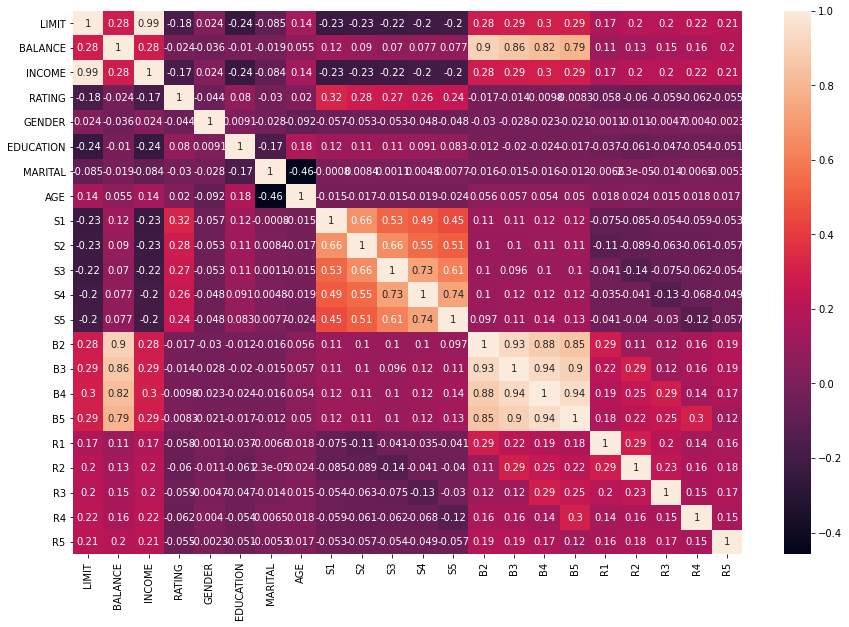

In [147]:
plt.figure(figsize = (15, 10))
corr_map = sns.heatmap(corr, annot = True)
plt.show()

In [148]:
def get_correlated(df, threshold):

    selected = []
    corr_matrix = df.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]
                selected.append((feature1, feature2))      
                
    return selected

# 0.7 is the standard threshold for data to be considered highly correlated.
to_drop = get_correlated(x, 0.7)
print(to_drop)

[('INCOME', 'LIMIT'), ('S4', 'S3'), ('S5', 'S4'), ('B2', 'BALANCE'), ('B3', 'BALANCE'), ('B3', 'B2'), ('B4', 'BALANCE'), ('B4', 'B2'), ('B4', 'B3'), ('B5', 'BALANCE'), ('B5', 'B2'), ('B5', 'B3'), ('B5', 'B4')]


In [149]:
def filter_correlated(to_drop, df, threshold):
    
    drop = set()
    
    overall_corr = df.corr()
    
    for feature_pair in to_drop:
        feature1, feature2 = feature_pair
        
        corr_val1 = abs(overall_corr[feature1]['B1'])
        corr_val2 = abs(overall_corr[feature2]['B1'])
        
        if corr_val1 < threshold and corr_val2 > threshold:
            drop.add(corr_val1)
            
        elif corr_val2 < threshold and corr_val1 > threshold:
            drop.add(corr_val2)
        
        elif corr_val1 < threshold and corr_val2 < threshold:    
            if corr_val1 > corr_val2:
                drop.add(feature2)
            else:
                drop.add(feature1)
            
    return drop
        
to_drop_filtered = filter_correlated(to_drop, df, 0.7)
to_drop_filtered

{'INCOME', 'S3', 'S5'}

Features are chosen based on correlation results, since linear regression assumes that there is no multicolinearity, we should drop one variable from the each pair of variables that is highly correlated with the other. This would also help make the model less complex and less prone to overfitting.

We can select this variable from a pair by it's correlation with B1 itself, it is highly correlated with B1, we will keep it, if it is not, we will keep the variable most correlated with B1 of the pair.

In [150]:
x = x.drop(to_drop_filtered, axis = 1)

In [151]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7) 

# Normalise features
def normalise(x):
    scaler = StandardScaler().fit(x)
    x = scaler.transform(x)
    return x

x_train_norm = normalise(x_train)
x_test_norm = normalise(x_test)


# Train linear regression model
model = lm.LinearRegression()
model.fit(x_train_norm, y_train)

LinearRegression()

In [157]:
y_predicted = model.predict(x_test_norm)

# Check MSE
mse = np.sqrt(metrics.mean_squared_error(y_test, y_predicted))

# Check R-squared
r2 = model.score(x_test_norm, y_test)

print('MSE: {mse}, R-Squared: {r2}'.format(mse = mse, r2 = r2))

MSE: 17057.456627176995, R-Squared: 0.9406874691473266


In [158]:
# Generating coefficients and intercept
print(model.coef_)
print(model.intercept_)

[ 4.85521007e+02  3.30608040e+04 -1.39060462e+01 -2.11302770e+02
  7.44162912e+01  3.90058820e+02  2.00541396e+01 -1.11601225e+03
  1.38689883e+03 -4.01568362e+02  3.95259570e+04 -5.92429678e+02
 -2.28311498e+03  2.76329126e+03 -5.76959945e+03  9.77957687e+02
 -7.30379520e+01 -8.42417070e+02 -1.28399579e+02]
49837.17877607151


In [159]:
def get_formula(model, variables):
    
    weight = [round(val, 3) for val in model.coef_]
    bias = round(model.intercept_, 3)
    
    formula = "B1 = "
    
    for i in range(len(variables)):
        if i == 0:
            formula += "{weight} * {var} ".format(weight = weight[i], var = variables[i])
            
        else:
            formula += "+ {weight} * {var} ".format(weight = weight[i], var = variables[i])
    
    formula += "+ {bias}".format(bias = bias)
    
    return formula

# Conclusion

In [161]:
f = "The formula is: {formula}".format(formula = get_formula(model, x.columns))
n = "The model performed with MSE of {MSE} and R-squared value of {R}.".format(MSE = round(mse, 3), R = round(r2, 3))
                                       
print(f)
print('\n')
print(n)

The formula is: B1 = 485.521 * LIMIT + 33060.804 * BALANCE + -13.906 * RATING + -211.303 * GENDER + 74.416 * EDUCATION + 390.059 * MARITAL + 20.054 * AGE + -1116.012 * S1 + 1386.899 * S2 + -401.568 * S4 + 39525.957 * B2 + -592.43 * B3 + -2283.115 * B4 + 2763.291 * B5 + -5769.599 * R1 + 977.958 * R2 + -73.038 * R3 + -842.417 * R4 + -128.4 * R5 + 49837.179


The model performed with MSE of 17057.457 and R-squared value of 0.941.
